<a href="https://colab.research.google.com/github/kellybrower/mlg/blob/master/Exercise_3_Link_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo](https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5ce6005b22f44fde8ced717c_MD%20Horizontal.png)

# Octavian.ai machine learning on graphs course

Welcome to our course on graph ML.

This course is primarily exercise based - you'll learn through reading and writing code, and answering the questions throughout these exercises.

[Join our Discord](https://discord.gg/a2Z82Te) to chat with fellow enthusiasts about this exercise and give us feedback to direct the next one.

## Exercise 3, graph convolutional networks - link prediction
In this exercise, you will learn how to predict edges in a graph. We'll do this by creating a graph network that passes messages along the edges of the graph. This technique is very versatile and with creativity can be applied to a wide range of graph problems.

Also, this course will emphasize the following new content:

* What is link prediction?

* What is negative sampling and how is it relevant to link prediction?

* What is an encoder/decoder and how does it relate to node embeddings?

* How do we leverage the model's embeddings to do link predictions?


## Introduction to Link Prediction in Graphs

### Problem Statement

Given the current state of graph, the goal is to predict the likelihood of a future association (link or edge) between two nodes, knowing that there is no association between the nodes in the current state of the graph. 

<img src="https://media.springernature.com/original/springer-static/image/art%3A10.1007%2Fs10462-017-9590-2/MediaObjects/10462_2017_9590_Fig2_HTML.gif" width="70%"/>

Figure 1

The image on the left above uses dashed lines to represent links that are missing from the graph. The image on the right uses yellow lines to indicate links that have been predicted to occur in the future. Moreoever:

>In effect, the link prediction problem asks: to what extent can the evolution of a social network be modeled using features intrinsic to the network topology itself? Can the current state of the network be used to predict future links? The link prediction problem is also related to the problem of inferring missing links from an observed network: in a number of domains, one constructs a network of interactions based on observable data and then tries to infer additional links that, while not directly visible, are likely to exist. [Link Prediction Algorithms](http://be.amazd.com/link-prediction/)

### Applications
Beyond social networks, link prediction has many other applications:
* In bioinformatics, link prediction can be used to find interactions between proteins [Airoldi et al. 2006](http://jmlr.csail.mit.edu/papers/volume9/airoldi08a/airoldi08a.pdf)
* In e-commerce, it can help build recommendation systems [Huang et al. 2005](https://www.researchgate.net/publication/263652875_A_graph_model_for_e-commerce_recommender_systems) such as the "people who bought this also bought" feature on Amazon
* In the security domain, link prediction can assist in identifying hidden groups of terrorists or criminals [Hasan et al. 2006](http://www.cs.rpi.edu/~zaki/PaperDir/LINK06.pdf).
* In co-authorship networks, many studies have been carried out (for example in scientific journals, with edges joining pairs who have co-authored papers). 







## Background on Link Prediction

How can you split a graph to achieve a learning task? First of all it is important to remember precisely our purpose : **we want to predict links (edges) between nodes**. 

The first capital information is the following one : the predictive algorithm will take as input node pairs and evaluate whether the nodes present the properties to be linked in the future. What remains to be clarified now is the output : how can we create ground-truth labels from the graph? The idea is to take a graph, hide some of its edges and monitor the results produced by the algorithm. For hidden links the label is 1, for non-existent links it is 0. No problem, let’s illustrate the concept with a minimal example:

<img src="https://i.ibb.co/DgC8jcB/full-test-training-graph.png" width="60%"/>

Figure 2

From the left to the right we have :

* The "full graph” which denotes as G_valid = (V, E_valid) with : V = {A, B, C, D, E, F, G, H, I, J} and E_valid = {(A,B); (A, D); (B, C); (B, D); (B, E); (C, D); (D, E); (D, F); (D, H); (D, G); (E, F); (E, I); (F, H); (F, I); (F, J); (I, J)}.
* The “test graph” where we have hidden two edges : G_test = (V, E_test) with E_test = E_valid \ {(D, E); (D, H)} thus E_test ⊂ E_valid.
* The “training graph” where we have hidden four more edges : G_train = (V, E_train) with E_train = E_test \ {(A, D); (C, D); (E, I); (F, J)} thus E_train ⊂ E_test.

The training set (with the corresponding labels) looks like the table below.

<img src="https://hackernoon.com/hn-images/1*230lw-B4t405x6rFJk2FvQ.png" width="15%"/>

The edge (D, H) for example has the label 0 here because it doesn’t exist in the Test Graph, even though it was originally present in the Validation Graph.



### Negative Sampling

First, some definitions:
* If the link exists in the graph, it is a *positive* sample. 
* If the link does not exist in the graph, it is a *negative* sample. 

The need of negative sampling comes from the fact that there are only positive examples in the dataset. To avoid trivial solutions of the embedding, for each positive sample in the dataset a set that contains its all possible negative samples needs to be hand-made.

In this demo, negative samples are generated by iterating through all the i-j node pairs (links) in the adjacency matrix, and checking if the link exists (meaning it is a positive example). If it does not exist, it is placed in a negative sample dataset.  See the code block below for details on how negative training samples are generated from the well-known Karate Club graph:

![Karate Club Graph](https://tkipf.github.io/graph-convolutional-networks/images/karate.png)

Figure 3

Karate club graph, colors denote communities obtained via modularity-based clustering ([Brandes et al., 2008](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.68.6623).


In [0]:
import networkx as nx
import numpy as np
import scipy.sparse as sp

# Utility method for converting a coordinate matrix to tuple form for easier inspection of the edge coordinates and number of edges
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

  # This function creates test edges for graphs with non-directed edges
def create_test_edges(g, percent_test_edges=10):
    # Create adjacency matrix from which we can derive the existing (positive) edges.
    adj = nx.adjacency_matrix(g)

    # To simplify this algorithm, we will ignore self-edges: remove diagonal elements from the adj matrix
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)

    # Check that diagonal is zero:
    assert np.diag(adj.todense()).sum() == 0

    # In a non-directed graph, the entries in the adj matrix in the upper triangle of the adj matrix refer to the same
    # edges in the lower triangle. To avoid these duplicate edges, just use the upper triangle.
    # Example: [1, 3] in the upper triangle refers to the same [3, 1] edge in the lower.
    adj_triu = sp.triu(adj)

    # Convert to tuple form for easier handling
    adj_tuple = sparse_to_tuple(adj_triu)

    # In tuple form, adj_tuple[0] references the numpy N-dimensional array of edges (e.g., [0 1] [0 2] [0 3] ...)
    edges = adj_tuple[0]

    # N-dimensional array edges.shape[0] dereferences the number of rows (edges) in the array.
    all_edge_idx = list(range(edges.shape[0]))
    np.random.shuffle(all_edge_idx)

    # Get number of test edges from the 'percent_test_edges' parameter
    # Example1: if we want 5% of all edges to be test ones, divide (100 / 5) = 20
    # Example2: if we want 10% of all edges to be test ones, divide (100 / 10) = 10
    num_test = int(np.floor(edges.shape[0] / (100. / percent_test_edges)))

    # Get 'num_test' number of test id indices.
    test_edge_idx = all_edge_idx[:num_test]

    # Get the test_edges using the test_edge_idx indices
    test_edges = edges[test_edge_idx]

    def ismember(a, b, tol=5):
        # calculate the difference between edges (i-j pairs) in arrays 'a' and 'b'.
        diff = a - b
        # If two edges in a and b have the same i-j values (e.g., a = [1, 2] b =[1, 2]), their difference is [0 0]
        # Check if both values in each member of the diff array are 0.  If they are, return True. Else, False.
        # Apply np.all to y-axis of the diff array (axis=1)
        rows_close = np.all((diff) == 0, axis=1)
        # If any of the diff pairs has a value of True (means 'a' was found in 'b'), return True, Otherwise, False.
        return np.any(rows_close)

    # Get all edges from the original adj matrix. We will need to check j-i entries as duplicates below
    edges_all = sparse_to_tuple(adj)[0]

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        # Since we have randomized the idx_i and idx_j values, we need to check for self-edges (e.g., [1, 1], [2, 2])
        # If we have a self-edge, ignore as we not are not modeling these kinds of edges.
        if idx_i == idx_j:
            continue
        # Since we have randomized the idx_i and idx_j values, we need to check all the edges to see if this edge
        # already exists. If it does, it is a positive edge, and thus not a candidate for the test_edges_false dataset.
        if ismember([idx_i, idx_j], edges_all):
            continue
        # Since we have randomized the idx_i and idx_j values, we need to check if idx_i and idx_j already exist in
        # the test_edges_false dataset. If they already exist, continue.
        if test_edges_false:
            if ismember([idx_j, idx_i], np.array(test_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(test_edges_false)):
                continue
        # Since all checks for invalid test edges have passed, add [idx_i, idx_j] to  test_edges_false
        test_edges_false.append([idx_i, idx_j])

    return test_edges, test_edges_false

# Get the popular karate club graph
g = nx.karate_club_graph()

# Generate positve and negative (false) edge datasets. Reminder: negative (false) edges do not exist in the karate club graph.
test_edges, test_edges_false = create_test_edges(g)
print("test_edges: ", test_edges)
print("test_edges_false:", test_edges_false)

test_edges:  [[ 1 21]
 [ 2  7]
 [ 2 28]
 [29 32]
 [ 0 10]
 [ 2  3]
 [13 33]]
test_edges_false: [[7, 11], [25, 10], [18, 21], [29, 7], [30, 24], [14, 28], [23, 3]]


## Theoretical background

The central problem in machine learning on graphs is finding a way to incorporate information about graph structure into a machine learning model. For example, in the case of link prediction in a social network, one
might want to encode pairwise properties between nodes, such as relationship strength or the number of common friends. 

To extract structural information from graphs, traditional machine approaches often rely on summary graph statistics (e.g., degrees or clustering coefficients), kernel functions, or carefully engineered features to measure local neighborhood structures. However, these approaches are limited because these handengineered features are inflexible—i.e., they cannot adapt during the learning process—and designing these features can be a time-consuming and expensive process.

### Encoding Structural Information from the Graph: Embeddings

More recently, there has been a surge of approaches that seek to ***learn representations*** that ***encode*** structural information about the graph. The idea behind these representation learning approaches is to learn a mapping that *embeds* nodes, or entire (sub)graphs, as points in a low-dimensional vector space *&#8477;<sup>d</sup>*. 

The goal is to optimize this mapping so that geometric relationships in the embedding space reflect the structure of the original graph. Below is an example of the Karate Club node classifications using 2-dimensional latent space which we can immediately visualize. 

![](https://tkipf.github.io/graph-convolutional-networks/images/karate_emb.png)

Figure 4

GCN embedding (with random weights) for nodes in the karate club network.

After optimizing the embedding space, the learned embeddings can be used as feature inputs for downstream machine learning tasks. The key distinction between representation learning approaches and previous work is how they treat the problem of representing graph structure. Representation learning approaches treat this problem as machine learning task itself, using a data-driven approach to learn ***embeddings*** that encode graph structure. [Hamilton, Yang, Jeskovich, 2017](https://arxiv.org/pdf/1709.05584.pdf). 

### Notation and Essential Assumptions

We will assume that the primary input to our representation learning algorithm is an undirected graph *G = (V, E)* with associated binary adjacency matrix A.  We also assume that the methods can make use of a real-valued matrix of node attributes *X ∈ &#8477;<sup>m×|V|</sup>*, m: number of samples (e.g., representing text or metadata associated with nodes). The goal is to use the information contained in A and X to map each node, or a subgraph, to a vector *z ∈ &#8477;<sup>d</sup>*, where *d << |V|*.  We will optimize this mapping in an unsupervised manner, making use of only information in A and X, without knowledge of a particular downstream machine learning task. 

## Encoder-Decoder Overview

Recent years have seen a surge of research on node embeddings. The goal is to train our embedding to represent liklihood of edges between nodes. Below is a diagram that illustrates the encoder-decoder approach. 

<img src="https://i.ibb.co/vCn22wj/encoder-decoder.png" width="60%"/>

Figure 5

First the encoder maps the node, v<sub>i</sub>, to a low-dimensional vector embedding, ***z<sub>i</sub>***, based on the node’s position in the graph, its local neighborhood structure, and/or its attributes. Next, the decoder extracts user-specified information from the low-dimensional embedding. This might be information about v<sub>i</sub>’s local graph neighborhood (e.g., the identity of its neighbors) or a classification label associated with v<sub>i</sub> (e.g., a community label). By jointly optimizing the encoder and decoder, the system learns to compress information about graph structure into the low-dimensional embedding space. 

The intuition behind the encoder-decoder idea is the following: 

> if we can learn to decode high-dimensional graph information—such as the global positions of nodes in the graph or the structure of local graph neighborhoods—from encoded low-dimensional embeddings, then, in principle, these embeddings should contain all information necessary for downstream machine learning tasks.

Adopting this encoder-decoder view, we organize our discussion of the various node embedding methods along the following four methodological components:
1. A **pairwise similarity function** s<sub>G</sub> : V × V → R+, defined over the graph G. This function measures the similarity between nodes in G.
2. An **encoder function**, ENC, that generates the node embeddings. This function contains a number of trainable parameters that are optimized during the training phase.
3. A **decoder function**, DEC, which reconstructs pairwise similarity values from the generated embeddings. This function usually contains no trainable parameters.
4. A **loss function**, l, which determines how the quality of the pairwise reconstructions is evaluated in order to train the model, i.e., how DEC(**z**<sub>i</sub>, **z**<sub>j</sub> ) is compared to the true s<sub>G</sub> (v<sub>i</sub>, v<sub>j</sub>) values.


### Encoder

Formally, the encoder is a function,
ENC : *V* → &#8477;<sup>d</sup>,
that maps nodes to vector embeddings <b>z</b><sub>i</sub> ∈ &#8477;<sup>d</sup> (where z<sub>i</sub> corresponds to the embedding for node v<sub>i</sub> ∈ *V*). 

#### Convolutional Encoder
Recently, deep learning algorithms have been applied to graph use cases, such as link prediction, with promising results. 

> In the last couple of years, a number of papers re-visited this problem of generalizing neural networks to work on arbitrarily structured graphs ([Bruna et al., ICLR 2014](http://arxiv.org/abs/1312.6203); [Henaff et al., 2015](http://arxiv.org/abs/1506.05163); [Duvenaud et al., NIPS 2015](http://papers.nips.cc/paper/5954-convolutional-networks-on-graphs-for-learning-molecular-fingerprints); [Li et al., ICLR 2016](https://arxiv.org/abs/1511.05493); [Defferrard et al., NIPS 2016](https://arxiv.org/abs/1606.09375); [Kipf & Welling, ICLR 2017](http://arxiv.org/abs/1609.02907), some of them now achieving very promising results in domains that have previously been dominated by, e.g., kernel-based methods, graph-based regularization techniques and others. [Kipf, ICLR 2017](https://tkipf.github.io/graph-convolutional-networks/)

Currently, most graph neural network models have a somewhat universal architecture in common. I will refer to these models as Graph Convolutional Networks (GCNs); convolutional, because filter parameters are typically shared over all locations in the graph (or a subset thereof as in Duvenaud et al., NIPS 2015):
> The lower layers of this network is convolutional in the sense that the same local filter is applied to each atom (node) and its neighborhood. After several such layers, a global pooling step combines features from all the atoms (nodes) in the molecule (neighborhood).  [Duvenaud et al., NIPS 2015](http://papers.nips.cc/paper/5954-convolutional-networks-on-graphs-for-learning-molecular-fingerprints)
A number of recent node embedding approaches use encoders that rely on a node’s local neighborhood, but not necessarily the entire graph. 

The intuition behind these approaches is that they generate ***embeddings for a node by aggregating information from its local neighborhood***. 

<img src="https://blog.sourced.tech/content/images/2019/04/gg-nn.png" width="80%"/>

Figure 6

Overview of encoding in the neighborhood aggregation methods. To generate an embedding for node A, the model aggregates messages from A’s local graph neighbors (i.e., B, C, and D), and in turn, the messages coming from these neighbors are based on information aggregated from their respective neighborhoods, and so on. A “depth-2” version of this idea is shown (i.e., information is aggregated from a two-hop neighborhood around node A), but in principle these methods can be of an arbitrary depth. At the final “depth” or “layer” the initial messages are based on the input node attributes.

These methods are often called *convolutional* because they represent a node as a function of its surrounding neighborhood, in a manner similar to the receptive field of a center-surround convolutional kernel in computer vision.

### Pairwise Decoder
The goal is to train our embedding to represent liklihood of edges between nodes. In principle, many decoders are possible; however, the vast majority of works use a basic pairwise decoder,

DEC : &#8477;<sup>d</sup> × &#8477;<sup>d</sup> → &#8477;<sup>+</sup>

that maps pairs of node embeddings to a real-valued node similarity measure, which quantifies the similarity of the two nodes in the original graph. When we apply the pairwise decoder to a pair of embeddings (<b>z</b><sub>i</sub>, <b>z</b><sub>j</sub>) we get a reconstruction of the similarity between v<sub>i</sub> and v<sub>j</sub> in the original graph, and the goal is optimize the encoder and decoder mappings to minimize the error, or loss, in this reconstruction so that:

DEC(ENC(v<sub>i</sub>), ENC(v<sub>j</sub> )) = DEC(<b>z</b><sub>i</sub>, <b>z</b><sub>j</sub> ) ≈ s<sub>G</sub>(v<sub>i</sub>, v<sub>j</sub>),

where s<sub>G</sub> is a user-defined, graph-based similarity measure between nodes, defined over the graph G. In this example, we will use s<sub>G</sub>(v<sub>j</sub> ) = A<sub>i</sub>,<sub>j</sub> and define nodes to have a similarity of 1 if they are adjacent and 0 otherwise.


### Further Reading

Thomas Kipf has published [really excellent articles](https://tkipf.github.io/graph-convolutional-networks/) about this area of technology, and this tutorial is based off of his basic network structure [outlined here](https://tkipf.github.io/graph-convolutional-networks/). You're encouraged to read Thomas's articles to get the full background on this technique. This exercise focuses on the application of it, as opposed to the background and theory.

This area of technology is still in its infancy; The capabilties of GCN have not been fully charted. Whilst working on this exercise, embrace a healthy relish for research and the unknown!

In what follows, we give a complete Tensorflow implementation of a two-layer graph convolutional neural network (GCN) for link prediction. We closely follow the GCN formulation as presented in [Kipf et al., ICLR 2017](https://arxiv.org/pdf/1609.02907.pdf).


## Dataset

We'll work with the Cora dataset. The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

Download Link 
https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

Related Papers: [Qing Lu, and Lise Getoor. "Link-based classification." ICML, 2003](https://linqspub.soe.ucsc.edu/basilic/web/Publications/2003/lu:icml03/).

[Prithviraj Sen, et al. "Collective classification in network data." AI Magazine, 2008](https://linqspub.soe.ucsc.edu/basilic/web/Publications/2008/sen:aimag08/).
 

## Demo

In this demo, we formulate this prediction task as a link prediction problem on unweighted and undirected networks and use a graph convolutional neural network to solve the task.

Note that link prediction is a standard prediction task, and thus this example can be easily extended and adapted to many other applications including biomedical and social graph cases.


### Demo structure

In this exercise you will create a fully functioning graph convolutional network. 

The exercise is a series of empty functions that you will fill out according to the instructions. There are then a series of unit tests to verify that your code works according to plan.

### Library setup

We'll write our code in Tensorflow 2.0. We'll also use Numpy and Scipy for some of the initial data manipulation. Let's load up all the libraries we'll need:

In [0]:
# Import all the libraries we need
!pip uninstall -q -y tensorflow
# install tensorflow 2
!pip install -q tensorflow==2.0.0

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from scipy.special import expit
import scipy.sparse as sp
from scipy.special import expit
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt 

import collections
from collections import namedtuple
import unittest
import os
import sys
import time

print("TensorFlow version: ", tf.__version__)

     |████████████████████████████████| 86.3MB 95kB/s 
     |████████████████████████████████| 450kB 51.6MB/s 
     |████████████████████████████████| 3.8MB 60.2MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
TensorFlow version:  2.0.0


## Data loading
We're going to use prepared data and code stored in a Kipf's [Graph Auto-Encoder github repo](https://github.com/tkipf/gae). The following code will download the data, the TensorFlow codebase, and load the data into memory.

In [0]:
%rm -rf /content/gae/
# Thanks to TKipf for the code in github and also for researching the use of GCNs for link prediction
!git clone https://github.com/tkipf/gae

# Add the GCN repo to the import path
sys.path.append('/content/gae/')

Cloning into 'gae'...
remote: Enumerating objects: 73, done.
remote: Total 73 (delta 0), reused 0 (delta 0), pack-reused 73
Unpacking objects: 100% (73/73), done.


In [0]:
# Load the data
%cd -q /content/gae/

from gae.input_data import load_data
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

%cd -q /content/gae/gae/
adj, features = load_data("cora")

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
print("Loaded",adj.shape[0],"nodes")
print("Loaded",adj.sum(),"edges")
print()
print("-- Data format --")
print("Full graph adjacency shape:    ", adj.shape, "\t",             type(adj), "number of indices", len(adj.indices))
print("Training graph adjacency shape:", adj_train.shape, "\t",       type(adj_train), "number of indices", len(adj_train.indices))
print("val_edges:                     ", val_edges.shape, "\t",       type(val_edges))
print("val_edges_false:               ", len(val_edges_false), "\t\t",type(val_edges_false))
print("test_edges:                    ", test_edges.shape,"\t",       type(test_edges))
print("test_edges_false:              ", len(test_edges_false),"\t\t",type(test_edges_false))

Loaded 2708 nodes
Loaded 10556 edges

-- Data format --
Full graph adjacency shape:     (2708, 2708) 	 <class 'scipy.sparse.csr.csr_matrix'> number of indices 10556
Training graph adjacency shape: (2708, 2708) 	 <class 'scipy.sparse.csr.csr_matrix'> number of indices 8976
val_edges:                      (263, 2) 	 <class 'numpy.ndarray'>
val_edges_false:                263 		 <class 'list'>
test_edges:                     (527, 2) 	 <class 'numpy.ndarray'>
test_edges_false:               527 		 <class 'list'>


## Graph Convolutional Network (GCN) Model

Let's take a look at the GCN model in more detail. Previously, we defined a GCN to be convolutional in the sense that the same local filter is applied to node and its neighborhood. The intuition behind these approaches is that they generate embeddings for a node by aggregating information from its local neighborhood. After several such layers, a step combines features from all the nodes in the neighborhood similar to a [global pooling step](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling) with [Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN).

***A*** is the adjacency matrix that describes the edges that below to each pair of nodes in the graph. For each node i and j in the graph, if they have an edge from i to j, then adj[i][j] == 1.0, else 0.0. Every neural network layer can then be written as a non-linear function

***H<sup>(l+1)</sup> = f(H<sup>(l)</sup>, A)***

with ***H<sup>(0)</sup>=X*** and ***H<sup>(L)</sup>=Z*** (or *z* for graph-level outputs), ***L*** being the number of layers. The specific models then differ only in how ***f(⋅,⋅)*** is chosen and parameterized. 

### Propagation Rule
As an example, let's consider the following very simple form of a layer-wise propagation rule:

***f(H<sup>(l)</sup>,A) = σ(AH<sup>(l)</sup>W<sup>(l)</sup>)***,

where ***W<sup>(l)</sup>*** is a weight matrix for the l-th neural network layer. It is the convolution (filter) in this model.

***σ(⋅)*** is a non-linear activation function like the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). 

### Limitations: Missing Self Links
But first, let us address two limitations of this simple model: multiplication with ***A*** means that, for every node, we sum up all the feature vectors of all neighboring nodes plus the node itself. However, most adjacency matrices will have zeros for the node 'itself', except in cases where self-loops exist. In order to include the node's features along with its neighbors' features, we need to add a self-loop entry for the node. We can enforce self-loops in the graph by adding the identity matrix ***I*** to ***A***.

### Limitations: Adjacency Matrix Not Normalized
The second major limitation is that ***A*** is typically not normalized and therefore the multiplication with ***A*** will completely change the scale of the feature vectors (we can understand that by looking at the eigenvalues of ***A***). Normalizing ***A*** such that all rows sum to one, i.e. ***D<sup>−1</sup>A***, where ***D*** is the diagonal node degree matrix, gets rid of this problem. Multiplying with ***D<sup>−1</sup>A*** now corresponds to taking the average of neighboring node features. In practice, dynamics get more interesting when we use a symmetric normalization, i.e. ***D<sup>−1/2</sup>AD<sup>−1/2</sup>*** (as this no longer amounts to mere averaging of neighboring nodes). 

### Renormalization Trick
Combining these two tricks, we essentially arrive at the propagation rule introduced in [Kipf et al., ICLR 2017](https://arxiv.org/pdf/1609.02907.pdf):

***f(H<sup>(l)</sup>,A) = σ(D̂<sup>−1/2</sup>Â D̂<sup>−1/2</sup> H<sup>(l)</sup> W<sup>(l)</sup>)***,

with ***Â = A + I***, where ***I*** is the identity matrix and ***D̂*** is the diagonal node degree matrix of ***Â***.

### Further Reading
See the [Kipf, Graph Convolutional Networks, 2017](https://tkipf.github.io/graph-convolutional-networks/) article for details.

More information will provided in the following sections.

## Data preparation

Below the renormalization of the adjacency matrix is implemented.

Note that the adjacency matrix is [sparse](https://en.wikipedia.org/wiki/Sparse_matrix): instead of storing every value in a *num nodes × num nodes × sizeof(float)* memory matrix (hint: that's a lot of memory!), just the non-zero values are stored as a list. Its internal structure is a [list of tuples](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html), each with a numeric value and a coordinate of where in the matrix that value appears. Storing it sparsely greatly reduces the memory footprint of the matrix.

Note: the *preprocess_graph* and *sparse_to_tuple* methods are imported utlilty methods. See [gae/preprocessing.py](https://github.com/tkipf/gae/blob/master/gae/preprocessing.py)  for details.

In [0]:
# The preprocess_graph method implements the renormalization 'trick'. See above for details.
adj_norm = preprocess_graph(adj)

# Since the adj_train matrix was not created with diagonal entires, add them now.
adj_label = adj_train + sp.eye(adj_train.shape[0])

# Use sparse_to_tuple to 'unpack' the COO object into edges, normalized adjacency values and normalized adjacency shape
adj_label = sparse_to_tuple(adj_label)

## Simple GCNs

As mentioned in the above section, GCNs use node features from a node's connected neighbors to do link prediction. One of the interesting conclusions from Kipf and Welling's research is that using the graph structure without any node features also (surprisingly?) results in accurate link predictions. 

The reader is encouraged to read Part III of the [Kipf's Graph Convolution Networks](https://tkipf.github.io/graph-convolutional-networks/) article for details on how a featureless approach results in accurate predictions.

### Featureless Model

Since this is training module, we will use the simplier, featureless approach, meaning the nodes in the Cora dataset will not have any features. 

Note: in a feature approach, the Cora dataset's node features are comprised of  a bag of words which are contained in the document (node). These words can be used to assist in predicting citation links. For example, documents that have a similar 'bag' of medical terms are more likely to have links than those that do not.

Instead of including node features, Kipf and Welling recommend using the identiy matrix ***I*** as the initial feature matrix ***X***.  We use the [scipy.sparse.identity](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.identity.html?highlight=identity) function, using the number of nodes as a parameter, to generated the identity matrix.


In [0]:
# Record the number of nodes and edges from the full adjacency matrix of the PPI yeast.edges dataset. Used below.
num_nodes = adj.shape[0]

# Simple GCN: no node features (featureless). Substitute the identity matrix for the feature matrix: X = I
# The sparse_to_tuple method 'unpacks' the sparse diagonal matrix into a tuple of node coordinates, values and shape
#
features = sparse_to_tuple(sp.identity(num_nodes))

# The features[2] dereferences the shape object in the features tuple. features[2][1] dereferences the number of unique nodes that can be neighbors of
# any node in the graph. Since we are using an identity matrix, the num_features is equal to the number of nodes in the graph.
# num_features are used by the GCN model below to define the input dimension size.
num_features = features[2][1]

# features[1] dereferences the data object in the features tuple and then use shape[0] to obtain the number of non-zero entries.
# Since we are using an identity matrix, the features_nonzero is equal to the number of nodes in the graph.
# features_nonzero is used by the dropout_sparse method to apply the dropout regularizer to non-zero features.
features_nonzero = features[1].shape[0]

# Dropout for sparse tensors. Currently fails for very large sparse tensors (>1M elements)
def dropout_sparse(x, keep_prob, num_nonzero_elems):
    noise_shape = [num_nonzero_elems]
    random_tensor = keep_prob
    random_tensor += tf.compat.v1.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.compat.v1.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)

## Tensorflow layer

Now for the exciting part, let's build a GCN layer in Tensorflow that we can use to construct a graph convolutional network.

The layer takes the *node_state* *([identity matrix](https://www.mathbootcamps.com/the-identity-matrix-and-its-properties/))*\* as the incoming tensor, then transforms that into a new *node_state*. It performs the following operations (many akin to a standard Dense layer):


1.   [Dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)
2.   [Graph convolution](https://tkipf.github.io/graph-convolutional-networks/) (i.e. multiplying the node state (identity matrix) by the weights matrix)
3.   [Graph propagation](https://tkipf.github.io/graph-convolutional-networks/) (i.e. multiplying the adjacency matrix by the node state)
4.   [Activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

\* In a simple GCN model with no node features, the *identity matrix* is used as the node feature matrix (*X = I*). 


### Graph convolution
This is convolution in the sense that the same parameters are being applied to each node state. This is in the form of a shared matrix, which transforms each node state just as a [dense layer](https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9) would transform the activations in a feed-forward network.

### Implementation details
The layer takes the adjacency matrix (the sparse matrix representing graph connectivity) as a parameter in its constructor. The adjacency matrix does not change during training or testing as our graph is static.

I've provided the main scaffold for the layer, initialising the weights and constructing the object.

#### Glorot (Xavier) Initialization

When you are working with deep neural networks, initializing the network with the right weights can be the hard to deal with because Deep Neural Networks suffer from problems called the [Vanishing/Exploding Gradients Problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) . Therefore, we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. Source: [Weight Initialization Schemes, Arat](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init)

One common initialization scheme for deep NNs is called Glorot (also known as Xavier) Initialization. The idea is to initialize each weight with a small Gaussian value with mean = 0.0 and variance based on the fan-in and fan-out of the weight. This works best for DNNs with multiple layers and a RELU activation function. Another way of saying this is to keep variance similar along all the layers of deep NN.  See [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) for details.









In [0]:
def weight_variable_glorot(input_dim, output_dim, name=""):
    """Create a weight variable with Glorot & Bengio (AISTATS 2010) initialization.
    """
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.compat.v1.random_uniform(
        [input_dim, output_dim],
        minval=-init_range,
        maxval=init_range,
        dtype=tf.float32)
    return tf.Variable(initial, name=name)

#### Encoder

An encoder is a network (e.g., FC, RNN, GCN, etc.) that takes the input, and output a feature map/vector/tensor. These feature vectors hold the information, the features, that represents the input. In other words, the encoder maps each entity v<sub>i</sub> ∈ V to a real-valued vector e<sub>i</sub> ∈ R<sup>d</sup>.


#### Graph Auto-encoder Model 
The research done by Schlichkrull, Kipf, et el. has computed representations through an R-GCN encoder with e<sub>i</sub> = h<sub>i</sub><sup>(L)</sup>, similar to the graph auto-encoder model introduced in [Variational Graph Auto-encoders, Kipf and Welling (2016)](https://arxiv.org/pdf/1611.07308.pdf) for unlabeled undirected graphs. [Modeling Relational Data with Graph Convolutional Networks, Schlichkrull, Kipf, et al., 2017](https://arxiv.org/abs/1703.06103). 

Below is an illustration of the architecture:

![Graph Auto-encoder](https://github.com/tkipf/gae/raw/master/figure.png)

Figure 7

Source: https://github.com/tkipf/gae

Notice that there are two hideen layers in the model above. These two layers will correspond to the next two classes described below:

- 1st Hidden Layer -> GraphConvolutionSparse class
- 2nd Hidden Layer -> GraphConvolution class

Details are given below.

### GraphConvolutionSparse Class

First of all, this class's node state (inputs) is a implemented as a [SparseTensor](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/sparse/placeholder).

The adjacency and feature matrices [sparse](https://en.wikipedia.org/wiki/Sparse_matrix) in that instead of storing every value in a *num nodes × num nodes × sizeof(float)* memory matrix (hint: that's a lot of memory!), just the non-zero values are stored as a list. Its internal structure is a [list of tuples](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html), each with a numeric value and a coordinate of where in the matrix that value appears. Storing it sparsely greatly reduces the memory footprint of the matrix. Using a sparse representation for A, memory requirement is O(|E|), i.e. linear in the number of edges. 

#### Practice Exercise 1

In order to reinforce the key ideas of link prediction with GCNs, this exercise will involve adding three lines of code to complete the graph convolution.

Note: you may find this method useful: 

* [tf.sparse.sparse_dense_matmul](https://www.tensorflow.org/api_docs/python/tf/sparse/sparse_dense_matmul)


In [0]:
class GraphConvolutionSparse():
    """Graph convolution layer for sparse inputs."""
    def __init__(self, input_dim, output_dim, adj, features_nonzero, dropout=0., act=tf.nn.relu, **kwargs):
        self.name = self.__class__.__name__.lower()
        self.vars = {}
        with tf.compat.v1.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name="weights")
        self.dropout = dropout
        self.adj = adj
        self.act = act
        self.issparse = True
        self.features_nonzero = features_nonzero

    def __call__(self, inputs):
        x = inputs
        x = dropout_sparse(x, 1-self.dropout, self.features_nonzero)
        # --- WRITE CODE HERE ---
        x =       # apply a matrix multiply sparse tensor function with x and weights variable
        x =       # apply a matrix multiply sparse tensor function with the adjacency matrix and x
        outputs = # pass x to the activation function
        # -----------------------
        return outputs

    def set_weights(self, weights):
        self.vars['weights'] = weights


SyntaxError: ignored

### GraphConvolution Class

Unlike the GraphConvolutionSparse class, this class has a node state (inputs) implemented as a standard [Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor), not a sparse one. The GraphConvolution class (hidden layer 2) is not sparse because the complete node state was output from the GraphConvolutionSparse class (hidden layer 1) as a standard tensor. 

Recall from a previous section the layer-wise propagation rule:

***f(H<sup>(l)</sup>,A) = σ(AH<sup>(l)</sup>W<sup>(l)</sup>)***,

***H<sup>(0)</sup>=X*** and ***H<sup>(L)</sup>=Z*** (or *z* for graph-level outputs), ***L*** being the number of layers. 

According to [Kipf and Welling, page 4](http://arxiv.org/abs/1609.02907), this propagation rule can be efficiently implemented as a product of a sparse matrix with a dense matrix. 

#### Practice Exercise 2

In order to reinforce the key ideas of link prediction with GCNs, this exercise will involve adding three lines of code to complete the graph convolution. You may find the following functions useful:

* [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul)
* [tf.sparse.sparse_dense_matmul](https://www.tensorflow.org/api_docs/python/tf/sparse/sparse_dense_matmul)

In [0]:
class GraphConvolution():
    """Basic graph convolution layer for undirected graph without edge labels."""
    def __init__(self, input_dim, output_dim, adj, dropout=0., act=tf.nn.relu, **kwargs):
        self.name = self.__class__.__name__.lower()
        self.vars = {}
        with tf.compat.v1.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name="weights")
        self.dropout = dropout
        self.adj = adj
        self.act = act
        self.issparse = False

    def __call__(self, inputs):
        x = inputs
        x = tf.compat.v1.nn.dropout(x, 1-self.dropout)
        # --- WRITE CODE HERE ---
        x =       # apply a matrix multiple function to x and the weights variable. Hint: are both matrices sparse or dense?
        x =       # apply a matrix multiple function to x and the adjacency matrix. Hint: are both matrices sparse or dense? 
        outputs = # apply the activation function to x
        # -----------------------
        return outputs

    def set_weights(self, weights):
        self.vars['weights'] = weights

### Decoder

The decoder is again a network (usually the same network structure as encoder but in opposite orientation) that takes the feature vector (embeddings) from the encoder, and gives the best closest match to the actual input or intended output. In other words, the decoder reconstructs edges of the graph relying on the vertex representations. [What is an Encoder/Decoder?](https://www.quora.com/What-is-an-Encoder-Decoder-in-Deep-Learning)


#### Dot Product Measure of Vector Similarity

Since the node embeddings are implemented as vectors, the strength of the relationship between two nodes is proportional to the *dot product* of their embeddings.  See [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) for more details on determining the similarity between two vectors.

The larger the dot product scalar value, the greater the strength of the association between the nodes.  This scalar is passed to the logistic sigmoid (expit) to return a probability value on how likely a link exists between the nodes.

Finally, the dot product is a normalized similarity measure and is less computational expensive compared to other measures.

Note that our choice of node similarity function is arbitrary and other options could have been used.

#### Practice Exercise 3

In order to reinforce the key ideas of link prediction with GCNs, this exercise will involve adding four lines of code to complete the graph convolution decoding. These methods may be useful:

* [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose)
* [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul)
* [tf.sparse.sparse_dense_matmul](https://www.tensorflow.org/api_docs/python/tf/sparse/sparse_dense_matmul)
* [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape)

In [0]:
# explain this in its own section and how it works. have text and diagram
class InnerProductDecoder():
    """Decoder model layer for link prediction."""
    def __init__(self, input_dim, dropout=0., act=tf.nn.sigmoid, **kwargs):
        self.dropout = dropout
        self.act = act

    def __call__(self, inputs):
        inputs = tf.compat.v1.nn.dropout(inputs, 1-self.dropout)
        # --- WRITE CODE HERE ---
        x =       # transpose the inputs variable
        x =       # apply a matrix multiple function to inputs and x
        x =       # flatten x into a 1-D tensor 
        outputs = # apply the activation function to x
        # -----------------------
        return outputs

    @staticmethod
    def predict_using_embeddings(embeddings, edges):
        # Taking the dot product of the (embeddings, embeddings.transpose) calculates the vector similarities between each 
        # pair of nodes.
        # adj_rec: adjacency matrix reconstructed from the node embeddings.
        adj_rec = np.dot(embeddings, embeddings.T)

        # The sigmoid function will take the strength of the node pair (edge) relationship as a scalar value from the reconstructed 
        # adjacency matrix, and return the probability that the edge exists.
        predictions = []
        for e in edges:
            # Note: the expit function is another name for the logistic sigmoid function
            predictions.append(expit(adj_rec[e[0], e[1]]))
        return predictions

### Test the GCN Models

In [0]:
class TestLayer(unittest.TestCase):
  def test_propagate_node_state(self):
      # Create a dummy adjacency matrix
      sparse_adj = tf.SparseTensor([(0, 1), (1, 0)], np.array([1.0, 1.0], np.float32), (3, 3))
      gcs = GraphConvolutionSparse(3, 3, sparse_adj, 3)
      weights = tf.constant([
          [1.0, 0.0],
          [0.0, 1.0],
          [0.0, 0.0]
      ])
      gcs.set_weights(weights)
      # Create an identity matrix below as the feature matrix X (node_state)
      node_state = tf.SparseTensor([(0, 0), (1, 1), (2, 2)], np.array([1.0, 1.0, 1.0], np.float32), (3, 3))
      result = gcs(node_state)
      expected_result = [
          [0.0, 1.0],
          [1.0, 0.0],
          [0.0, 0.0]
      ]
      np.testing.assert_allclose(result, expected_result, rtol=1e-03)
      print("test_propagate_node_state Success!")

  def test_apply_convolution(self):
      sparse_adj = tf.SparseTensor([(0, 1), (1, 0)], np.array([1.0, 1.0], np.float32), (3, 3))
      gcs = GraphConvolution(3, 3, sparse_adj)
      weights = tf.constant([
          [0.0, 1.0],
          [1.0, 0.0],
      ])
      gcs.set_weights(weights)
      # Create an identity matrix below as the feature matrix (node_state) X
      node_state = tf.constant([
          [1.0, 0.0],
          [1.0, 0.0],
          [0.0, 0.0]
      ], tf.float32)
      node_state = tf.convert_to_tensor(node_state, dtype=tf.float32)
      result = gcs(node_state)
      expected_result = [
          [0.0, 1.0],
          [0.0, 1.0],
          [0.0, 0.0]
      ]
      np.testing.assert_allclose(result, expected_result, rtol=1e-03)
      print("test_apply_convolution Success!")

  def test_decoder(self):
      embeddings = [
          [0.0, 1.0],
          [0.0, 1.0],
          [0.0, 0.0]
      ]
      embeddings = tf.convert_to_tensor(embeddings, dtype=tf.float32)
      decoder = InnerProductDecoder(3, act=lambda x: x)
      result = decoder(embeddings)
      expected_result = np.array([1., 1., 0., 1., 1., 0., 0., 0., 0.])
      np.testing.assert_allclose(result, expected_result, rtol=1e-03)
      print("test_decoder_Success!")

t = TestLayer()
t.test_propagate_node_state()
t.test_apply_convolution()
t.test_decoder()

test_propagate_node_state Success!
test_apply_convolution Success!
test_decoder_Success!


## Tensorflow model

Now we have a working GCN layer, let's put it to work in a Tensorflow model. We will stack multiple layers linearly, passing the output of one as the input to the next.

We're going to build the following network architecture - two layers, with the following parameters:

1.   Output units = 32, activation = relu
2.   Output units = 16, activation = identity function

We'll give each layer our prepared adjacency matrix from earlier.

I've provided hyper-parameters for the number of units in each 
GCN layer and [dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/).

In [0]:
HIDDEN1=32
HIDDEN2=16
DROPOUT=0.1

class GCNModelAE():
    def __init__(self, placeholders, num_features, features_nonzero, **kwargs):
        self.name = self.__class__.__name__.lower()
        self.inputs = placeholders['features']
        self.input_dim = num_features
        self.features_nonzero = features_nonzero
        self.adj = placeholders['adj']
        self.dropout = placeholders['dropout']
        self.build()

    def _build(self):
        self.hidden1 = GraphConvolutionSparse(input_dim=self.input_dim,
                                              output_dim=HIDDEN1,
                                              adj=self.adj,
                                              features_nonzero=self.features_nonzero,
                                              act=tf.nn.relu,
                                              dropout=self.dropout)(self.inputs)

        self.embeddings = GraphConvolution(input_dim=HIDDEN1,
                                           output_dim=HIDDEN2,
                                           adj=self.adj,
                                           act=lambda x: x,
                                           dropout=self.dropout)(self.hidden1)

        self.z_mean = self.embeddings

        self.reconstructions = InnerProductDecoder(input_dim=HIDDEN2,
                                      act=lambda x: x)(self.embeddings)

    def build(self):
        """ Wrapper for _build() """
        with tf.compat.v1.variable_scope(self.name):
            self._build()
        variables = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}


### Optimizer
I've provided a custom Optimizer class. At its core, this custom optimizer uses a [weighted cross entropy with logits](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/nn/weighted_cross_entropy_with_logits) loss function.  A value pos_weight > 1 decreases the false negative count, hence increasing the recall. This can be seen from the fact that pos_weight is introduced as a multiplicative coefficient for the positive labels term in the loss expression:

An explanation for this choice of loss function is mentioned in [Modeling Relational Data with Graph Convolutional Networks](https://arxiv.org/pdf/1703.06103.pdf), page 4:

>As in previous work on factorization (Yang et al. 2014;
Trouillon et al. 2016), we train the model with negative
sampling. For each observed example we sample ω negative ones. We sample by randomly corrupting either the subject or the object of each positive example. We optimize for cross-entropy loss to push the model to score observable
triples higher than the negative ones.

The `norm` variable accounts for the sparsity of positive links in the graph. Since we are increasing the weight of the positive links with the `pos_weight` variable, the `norm` variable normalizes this cost according to the sparsity.  The fewer the positive links, the smaller the normalization factor value. The higher the positive links, the larger the value.

 [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is used as the Tensorflow optimizer.

In [0]:
LEARNING_RATE=0.1

class OptimizerAE(object):
    def __init__(self, preds, labels, pos_weight, norm):
        preds_sub = preds
        labels_sub = labels

        self.cost = norm * tf.reduce_mean(tf.compat.v1.nn.weighted_cross_entropy_with_logits(logits=preds_sub, labels=labels_sub, pos_weight=pos_weight))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE)  # Adam Optimizer

        self.opt_op = self.optimizer.minimize(self.cost)
        self.grads_vars = self.optimizer.compute_gradients(self.cost)


## Doing Predictions 

Recall that we are using the learned node embeddings to do predictions, use code below to implement this approach.

See the *InnerProductDecoder.predict_using_embeddings* method defined above for how the predictions are calculated. 

The predictions are done separately on postive and negative edges, combined into one dataset, and then passed to [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score) and 
[sklearn.metrics.average_precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) methods to calculate ROC and average precision respectively.

### ROC Curve

A receiver operating characteristic curve, or [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. To draw an ROC curve, only the true positive rate (TPR) and false positive rate (FPR) are needed (as functions of some classifier parameter). The TPR defines how many correct positive results occur among all positive samples available during the test. FPR, on the other hand, defines how many incorrect positive results occur among all negative samples available during the test.

#### ROC Space

An ROC space is defined by FPR and TPR as x and y axes, respectively, which depicts relative trade-offs between true positive (benefits) and false positive (costs). Since TPR is equivalent to sensitivity and FPR is equal to 1 − specificity, the ROC graph is sometimes called the sensitivity vs (1 − specificity) plot. Each prediction result or instance of a confusion matrix represents one point in the ROC space.

#### Understanding ROC Values
The best possible prediction method would yield a point in the upper left corner or coordinate (0,1) of the ROC space, representing 100% sensitivity (no false negatives) and 100% specificity (no false positives). The (0,1) point is also called a perfect classification. A random guess would give a point along a diagonal line (the so-called line of no-discrimination) from the left bottom to the top right corners (regardless of the positive and negative base rates). An intuitive example of random guessing is a decision by flipping coins. As the size of the sample increases, a random classifier's ROC point tends towards the diagonal line. In the case of a balanced coin, it will tend to the point (0.5, 0.5).  Here is an example:

![Sample ROC Curve](https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/ROC_space-2.png/500px-ROC_space-2.png)

Figure 8

The diagonal divides the ROC space. Points above the diagonal represent good classification results (better than random); points below the line represent bad results (worse than random).

When using normalized units, the area under the curve (often referred to as simply the AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one (assuming 'positive' ranks higher than 'negative').

### Average Precision

[AP](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision) summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

<img src="https://i.ibb.co/qMv4HMK/Screen-Shot-2019-10-29-at-11-17-45-AM.png" width="20%"/>

where *k* is the rank in the sequence of retrieved documents, *n* is the number of retrieved documents, *P(k)* is the precision at cut-off *k* in the list, and  &#916;*r(k)* is the change in recall from items *k-1* to *k*. The closer the AP is to 1.0, the fewer false positives and false negatives predicted from the model.


In [0]:
def get_roc_score(edges_pos, edges_neg):
    # Since we are using the embeddings in a test scenario, recalculate them with no dropout. 
    feed_dict.update({placeholders['dropout']: 0})
    emb = sess.run(model.embeddings, feed_dict=feed_dict)
       
    # Since we are using the embeddings in a test scenario, recalculate them with no dropout.
    feed_dict.update({placeholders['dropout']: 0})
    emb = sess.run(model.embeddings, feed_dict=feed_dict)
    
    # Predict on test set of positive edges
    preds = InnerProductDecoder.predict_using_embeddings(emb, edges_pos)
    
    # Predict on test set of negative edges
    preds_neg = InnerProductDecoder.predict_using_embeddings(emb, edges_neg)

    # Stack positive/negative predictions and labels 
    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    
    # Calculate scores
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

## Train the model

Finally, let's train the model.  Running this assumes the user has some familiarity with running [TensorFlow](https://www.tensorflow.org/) models. 


In [0]:
NUM_EPOCHS=200
DROPOUT=0.1

def construct_feed_dict(adj_normalized, adj, features, placeholders):
    # construct feed dictionary
    feed_dict = dict()
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['adj']: adj_normalized})
    feed_dict.update({placeholders['adj_orig']: adj})
    return feed_dict

tf.compat.v1.disable_eager_execution()

# Define placeholders
placeholders = {
    'features': tf.compat.v1.sparse_placeholder(tf.float32),
    'adj': tf.compat.v1.sparse_placeholder(tf.float32),
    'adj_orig': tf.compat.v1.sparse_placeholder(tf.float32),
    'dropout': tf.compat.v1.placeholder_with_default(0., shape=())
}

# Create model
model = GCNModelAE(placeholders, num_features, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):
    opt = OptimizerAE(preds=model.reconstructions,
                      labels=tf.reshape(tf.compat.v1.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                  validate_indices=False), [-1]),
                      pos_weight=pos_weight,
                      norm=norm)
 
print("Finished creating optimizer")

# Initialize session
print("Start session")
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

# Construct feed dictionary
feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)

cost_val = []
ap_val = []
auc_score_val = []
# Train model
print("Epochs: ")
for epoch in range(NUM_EPOCHS):
    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: DROPOUT})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    cost_val.append(avg_cost)

    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    ap_val.append(ap_curr)
    auc_score_val.append(roc_curr)

    # print("Epoch:", '%04d' % (epoch + 1), 
    #      "train_loss=", "{:.5f}".format(avg_cost),
    #      "val_roc=", "{:.5f}".format(roc_curr[-1]),
    #      "val_ap=", "{:.5f}".format(ap_curr),
    #      "time=", "{:.5f}".format(time.time() - t))
    if epoch % 40 == 0:
      print("")
    print(epoch, end =" ")

print('\nOptimization Finished!')

Finished creating optimizer
Start session
Epochs: 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 
120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 
160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
Optimization Finished!


Final loss:  0.41271728


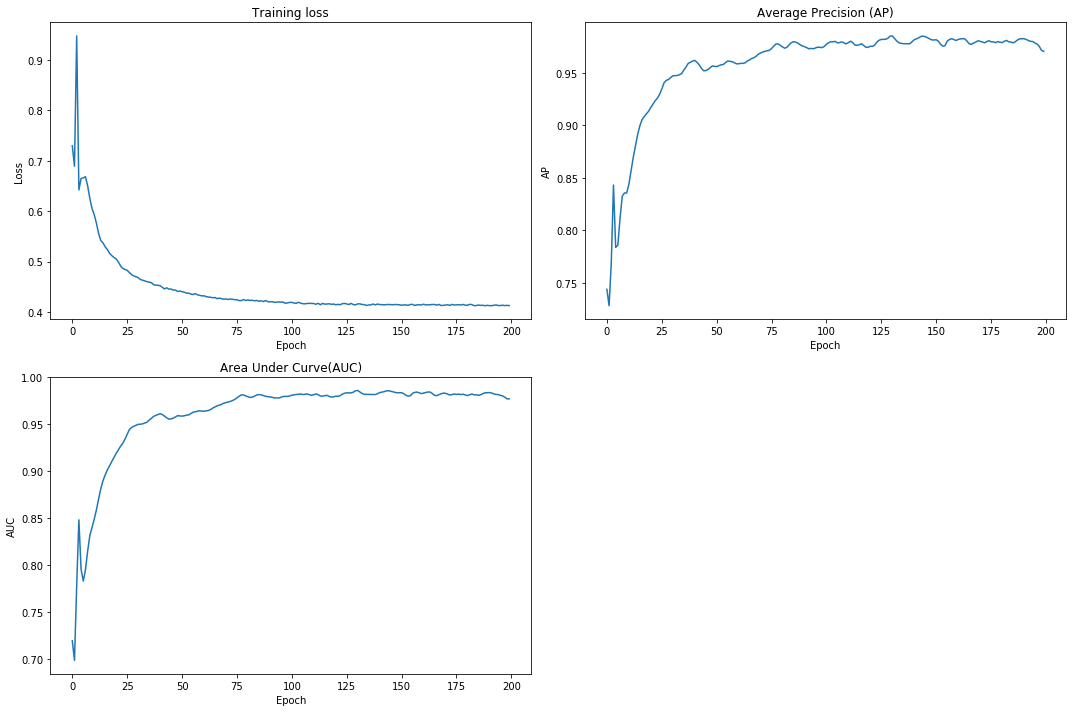

In [0]:
# Display graphs of how the model performed
from scipy.ndimage.filters import gaussian_filter1d

print("Final loss: ", cost_val[-1])

plt.rcParams['figure.figsize'] = [15, 10]

plt.subplot(2, 2, 1)
plt.plot(cost_val)
plt.title("Training loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2, 2, 2)
plt.plot(ap_val)
plt.title("Average Precision (AP)")
plt.ylabel('AP')
plt.xlabel('Epoch')

plt.subplot(2, 2, 3)
plt.plot(auc_score_val)
plt.title("Area Under Curve(AUC)")
plt.ylabel('AUC')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

## Test the model

Rerun the model with hold-out test datasets: test_edges, test_edges_false.

In [0]:
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test AUC score: {:.5f}'.format(roc_score))
print('Test AP score: {:.5f}'.format(ap_score))

Test AUC score: 0.98276
Test AP score: 0.98177


## Comparing Results to Published Research

Kipf and Welling in their paper [Variational Graph Auto-Encoders, 2016](https://arxiv.org/pdf/1611.07308.pdf) reported link prediction results (Table 1) for the Cora dataset:

**AUC: 91.0 ± 0.02**

**AP: 92.0 ± 0.0**


## Exercise questions


[Add your answers and discoveries to the answer document](https://docs.google.com/document/d/1bNm0yVGTtW12y52-vyMzOGouh9M6dhtIm6xmDpA5xSQ/edit?usp=sharing)


- What AUC and average precision did you get?

- What did you observe regarding the Cost, AP and AUC curves?

- Did you perform better or worse than the Kipf and Welling?

- How would you scale this network to a larger graph? What challenges might you encounter?

## Feedback

You can send feedback to [Paul Sterk](mailto:paul.j.sterk@gmail.com), the [Octavian Discord Chat Channel](https://discordapp.com/channels/391272409681887255/391272410252574732) or the [Octavian Mailing List](mailto:hello@octavian.ai).

